 Sections
--------
1. Load utils
2. Load data
3. Stack images
4. Training and Validation data sets
5. Build classifiers
6. Classification
7. Confusion matrix
8. Classification report

## Load utils

In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
from rasterio.plot import reshape_as_image
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

import copy

## Load data

In [2]:
def normalize(data):
    """ Normalizes the data with min-max scaling."""
    data_min = data.min()
    data_max = data.max()
    data_norm = (data - data_min) / (data_max - data_min)
    return data_norm

In [3]:
def Load_raster(path):
    """This function read the dataset into the memory performs data normalizaton;
    it returns the data as a numpy array and the normlized image in (bands, row, col) structure"""
    src = rasterio.open(path)
    img = src.read()   # load our original input file bands to a numby array stack
    # deep copy img to avoid changing the original data
    img_copy = copy.deepcopy(img)
    # normalise img
    img_norm = normalize(img_copy)
    src_profile = src.profile
    src_profile.update(dtype=rasterio.float64, nodata=np.nan)
    profile = src_profile  # the copy the profile of the original GeoTIFF input file
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(**profile) as dst:
            for i in range(0, src.count):
                dst.write(img_norm[i], i+1)
        dataset = memfile.open()
        return dataset, img_norm

In [4]:
# read rgb data into memory
rgb_mem, rsa = Load_raster('raster/RGB.tif')
# read nir data into memory
nir_mem, nir_rsa = Load_raster('raster/NIR3.tif')
# read reg data into memory
reg_mem, reg_rsa = Load_raster('raster/REG3.tif')
# read dsm data into memory
# dsm_mem, dsm_rsa = Load_raster('raster/DSM3.tif')

### Normalization

In [5]:
# data normalization with min-max scaling
def normalize(data):
    """ Normalizes the data with min-max scaling."""
    data_min = data.min()
    data_max = data.max()
    data_norm = (data - data_min) / (data_max - data_min)
    return data_norm

## Training and Validation data sets

The few sampling points were selceted traninng (45) and validation (35); for training and validation set 7 andd 5 points were selected respectively.

In [5]:
# class name
class_name = ['roof',  'water', 'road', 'grass', 'tree','sediment', 'bush'] # seven classes  

# training and validation paths
training_set_path = 'shapefile/training_set.shp'
validation_set_path = 'shapefile/validation_set.shp'

Training set shapefiles and its raster values as a Dataframe

In [6]:
train_points = gp.read_file(training_set_path)
coords = [(x,y) for x,y in zip(train_points.geometry.x, train_points.geometry.y)]

def get_raster_value(coords, raster, train_points, bands):#, composite_raster = 'rgb'):
    """ Returns the raster value of the given coordinates."""
    # get the raster value as float for the given coordinates
    train_points['value'] = [x for x in raster.sample(coords)]
    train_points[bands] = pd.DataFrame(train_points['value'].values.tolist(), index=train_points.index)
    train_points = train_points.drop(['value'], axis=1)
    train_points = train_points.drop(['geometry'], axis=1)
    # train_points.to_csv('%s.csv'%composite_raster)
    return train_points

# rgb bands
rgb_bands = ['red', 'green', 'blue']
rgb_train_points = get_raster_value(coords, rgb_mem, train_points, rgb_bands)#, 'rgb')
# nir bands
nir_train_points = get_raster_value(coords, nir_mem, train_points, 'nir')
# # reg bands
reg_train_points = get_raster_value(coords, reg_mem, train_points, 'reg')
# dsm bands
# dsm_train_points = get_raster_value(coords, dsm_mem, train_points, 'dsm')

In [7]:
X  = train_points.drop(['class_code', 'value'], axis=1)
y = train_points['class_code']
X.head()

,id,geometry,red,green,blue,nir,reg
0,1,POINT (319895.549 6843677.891),0.992157,0.980392,0.898039,0.445045,0.590909
1,2,POINT (319899.667 6843671.832),0.890196,0.709804,0.584314,0.452811,0.863636
2,3,POINT (319904.095 6843671.016),0.992157,0.996078,0.870588,0.811627,0.772727
3,4,POINT (319908.057 6843682.785),0.203922,0.345098,0.603922,0.052491,0.590909
4,5,POINT (319890.461 6843664.568),0.152941,0.196078,0.349020,0.079973,0.590909


Validation set

In [8]:
validation_points = gp.read_file(validation_set_path)
coords = [(x,y) for x,y in zip(validation_points.geometry.x, validation_points.geometry.y)]

# validation rgb bands
rgb_validation_points = get_raster_value(coords, rgb_mem, validation_points, rgb_bands)#, 'rgb')
# validation nir bands
nir_validation_points = get_raster_value(coords, nir_mem, validation_points, 'nir')
# validation reg bands
reg_validation_points = get_raster_value(coords, reg_mem, validation_points, 'reg')
# validation dsm bands
# dsm_validation_points = get_raster_value(coords, dsm_mem, validation_points, 'dsm')

In [9]:
X_validation  = validation_points.drop(['class_code', 'value'], axis=1)
y_validation = validation_points['class_code']
X_validation.head()

,id,geometry,red,green,blue,nir,reg
0,1,POINT (319897.908 6843666.771),0.380392,0.290196,0.239216,0.371710,0.863636
1,2,POINT (319902.470 6843668.292),0.313725,0.239216,0.250980,0.082353,0.772727
2,3,POINT (319896.054 6843680.885),0.666667,0.568627,0.580392,0.321431,0.590909
3,4,POINT (319906.509 6843677.511),0.474510,0.282353,0.298039,0.167727,0.727273
4,5,POINT (319901.757 6843685.257),0.227451,0.384314,0.631373,0.053971,0.500000


## Build classifiers

### Random Forest

Random forest model for training set

In [10]:
from sklearn.ensemble import RandomForestClassifier
#ignore warnings

import warnings
warnings.filterwarnings('ignore')

def train_model(X_train, y_train):
    """ Trains a random forest model."""
    model = RandomForestClassifier(n_estimators=50, oob_score=True, max_features='auto', random_state=42)
    model.fit(X_train, y_train)
    return model
#train model
# for RGB
xtrain_rgb = X[['red', 'green', 'blue']]
rgb_model = train_model(xtrain_rgb, y)
# for RGB + NIR
xtrain_rgb_nir = X[['red', 'green', 'blue', 'nir']]
rgb_nir_model = train_model(xtrain_rgb_nir, y)
# for RGB + NIR + REG
xtrain_rgb_nir_reg = X[['red', 'green', 'blue', 'nir', 'reg']]
rgb_nir_reg_model = train_model(xtrain_rgb_nir_reg, y)

Random forest model predicted on the validation set

In [46]:
# accuracy metrics sklearn
from sklearn.metrics import accuracy_score#, precision_score, recall_score, f1_score
def validation_model(X_validation, y_validation, model):
    """ Validates the model."""
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    # print('Validation accuracy: %.2f' % accuracy)
    return accuracy

#rgb validation
xval_rgb = X_validation[['red', 'green', 'blue']]
print('RGB validation accuracy: %.2f' % validation_model(xval_rgb, y_validation, rgb_model))
#rgb + nir validation
xval_rgb_nir = X_validation[['red', 'green', 'blue', 'nir']]
print('RGB + NIR validation accuracy: %.2f' % validation_model(xval_rgb_nir, y_validation, rgb_nir_model))
# #rgb + nir + reg validation
xval_rgb_nir_reg = X_validation[['red', 'green', 'blue', 'nir', 'reg']]
print('RGB + NIR + REG validation accuracy: %.2f' % validation_model(xval_rgb_nir_reg, y_validation, rgb_nir_reg_model))

RGB validation accuracy: 0.34
RGB + NIR validation accuracy: 0.40
RGB + NIR + REG validation accuracy: 0.63


Confusion matrix for training set and validation set

RGB confusion matrix


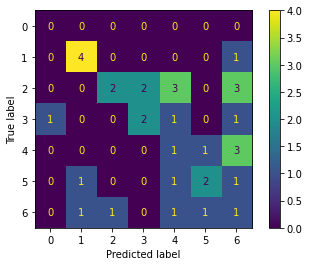

RGB + NIR confusion matrix


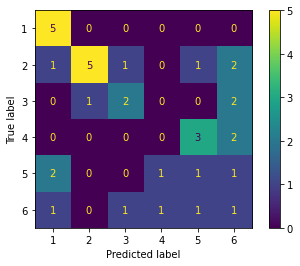

RGB + NIR + REG confusion matrix


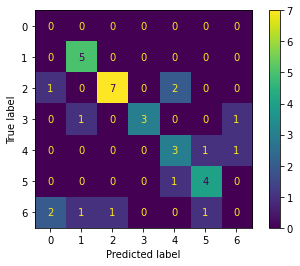

In [16]:
# build a confusion matrix for training and validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

def confusion_matrix_model(X_validation, y_validation, model):
    """" build and plot confuson matrix."""
    y_pred = model.predict(X_validation)
    cm = confusion_matrix(y_validation, y_pred)
    # print(cm)
    plot_confusion_matrix(model, X_validation, y_validation)
    plt.show()


#rgb confusion matrix
print('RGB confusion matrix')
confusion_matrix_model(xval_rgb, y_validation, rgb_model)
#rgb + nir confusion matrix
print('RGB + NIR confusion matrix')
confusion_matrix_model(xval_rgb_nir, y_validation, rgb_nir_model)
#rgb + nir + reg confusion matrix
print('RGB + NIR + REG confusion matrix')
confusion_matrix_model(xval_rgb_nir_reg, y_validation, rgb_nir_reg_model)
plt.show()

Plot feature importance

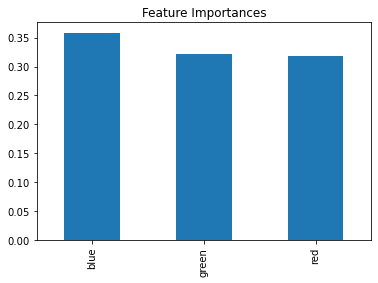

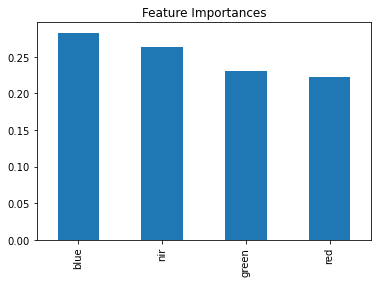

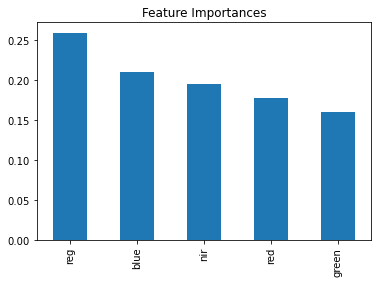

In [58]:
# plot the feature importance for the models

def plot_feature_importance(model, X_train):
    """ Plots the feature importance for the models."""
    # get the feature importances
    importances = model.feature_importances_
    # convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
    f_importances = pd.Series(importances, X_train.columns)
    # sort the array in descending order of the importances
    f_importances.sort_values(ascending=False, inplace=True)
    # make the bar Plot from f_importances
    f_importances.plot(kind='bar', title='Feature Importances')
    plt.show()

# for rgb
plot_feature_importance(rgb_model, xtrain_rgb)

# for rgb + nir
plot_feature_importance(rgb_nir_model, xtrain_rgb_nir)

# for rgb + nir + reg
plot_feature_importance(rgb_nir_reg_model, xtrain_rgb_nir_reg)

## Classification with models

In [17]:
# color dictionary for class_code 
colors = dict((
    # roof
    (0, (255,0,0,255)), 
    # water
    (1, (0,76,153,255)),
    # road
    (2, (160,160,160,255)),
    # sediment
    (3, (255,204,153,255)),
    # Tree
    (4, (51,255,51,255)),
    # Grass
    (5, (0,255,0,255)),
    # bush
    (6, (204,255,153,255))
))

# convert 0-255 values to 0-1 values
for k, v in colors.items():
    colors[k] = [x/255 for x in v]

# matplotlib colormap from color dictionary
index_colors = [colors[x] if x in colors else (0,0,0,1) for x in range(0,7)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', 7)

Classification on the image

The p

In [38]:
#stack the rgb, nir and reg data into a single array
red, green, blue = rgb_mem.read()
nir = nir_mem.read(1)
reg = reg_mem.read(1)

rgbn_stack = np.dstack((red, green, blue, nir, reg))
rgbn_stack.shape

(9370, 8404, 5)

In [ ]:
def read_input_combination(band_combination, x_subset):
    """ Returns the input combination based on input bands."""
    bands = band_combination.read()
    #reshape as (rows, cols, bands)
    band_reshaped = reshape_as_image(bands)
    # reshape as ((rows*cols), bands)
    input_raster = band_reshaped.reshape(-1, x_subset.shape[1])

    return input_raster, band_reshaped

# for xval_rgb_nir_reg
xval_rgb_nir_reg_input, band_reshaped = read_input_combination(rgbn_stack, xval_rgb_nir_reg)

In [44]:
#reshape as ((rows*cols), bands)
reshape__d = rgbn_stack.reshape(-1, xval_rgb_nir_reg.shape[1])

In [47]:
# prediction on reshaped image using rgb model
class_rgb_nir_reg = rgb_nir_reg_model.predict(reshape__d)

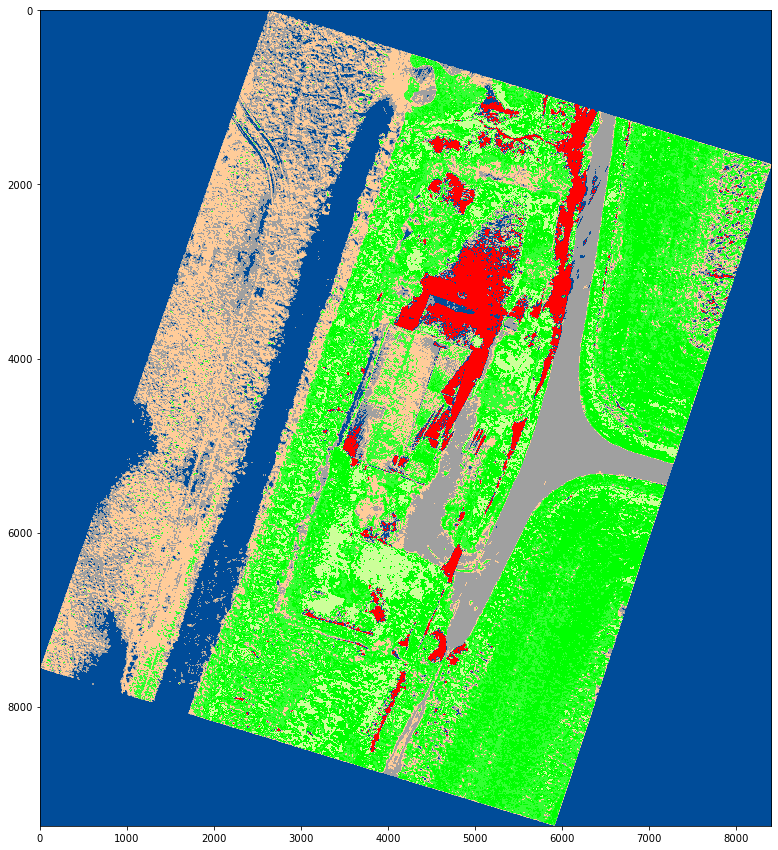

In [51]:
cl = class_rgb_nir_reg.reshape(band_reshaped[:,:,0].shape)

plt.figure(figsize=(15,15))
plt.imshow(cl, cmap=cmap)
plt.show()